In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_clus_size_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.00003, 0.001, 900]


times = np.linspace(50, 90, 41)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:41,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((41,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_22560/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.


Iter. Eval. Time m:s
0     3       0:00.4
1     501     0:04.9
2     1005    0:06.4
3     1500    0:10.6
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.3561798692083D+02   r2 =  0.8190346357972D-16


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.8670181783969D+02   r2 =  0.2272960891621D-08
 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.4948017536131D+02   r2 =  0.4625260516805D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4909515786667D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1198612252604D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h 

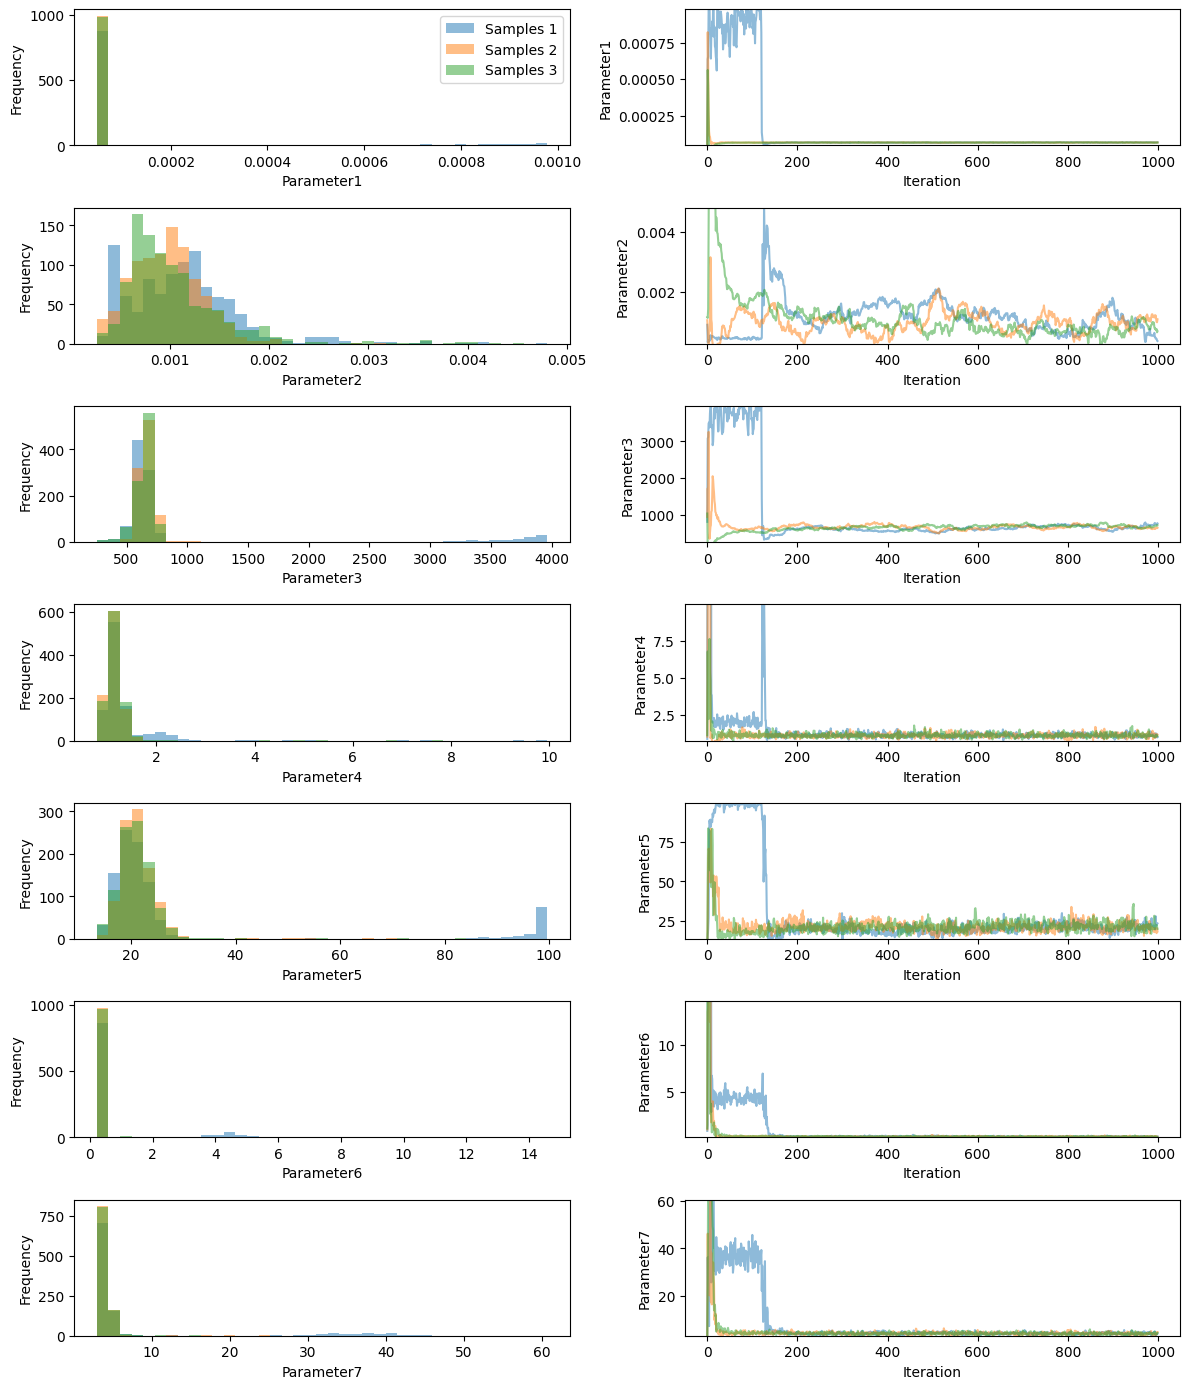

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# y0 = np.array([0.0003, 0.01, 1100,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0001, 0.01, 1100,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0003, 0.001, 1100,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0001, 0.001, 1100,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)

# y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

# boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
#     prior_arr_upper)

# opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
# opt.set_log_to_screen(False)
# y1, g1 = opt.run()
# print('Estimated parameters:')
# print(y1)


In [9]:
print(log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00]))

AIC = 2*7 - 2*log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00])

print(AIC)

-535454735456.1684
1070909470926.3368


In [21]:

# ITERS = 100
AllChains = chains[0,200:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(800, 7)
[6.69637304e-05 1.13466117e-03 6.19456146e+02 1.10318574e+00
 1.91177995e+01 3.04609083e-01 4.65344265e+00]
[[6.69637304e-05 1.13466117e-03 6.19456146e+02 ... 1.91177995e+01
  3.04609083e-01 4.65344265e+00]
 [6.75506363e-05 1.19871712e-03 6.23934947e+02 ... 2.03281554e+01
  2.66599453e-01 4.62612713e+00]
 [6.62107276e-05 1.32410612e-03 6.04360541e+02 ... 1.78385630e+01
  3.26538367e-01 3.65246296e+00]
 ...
 [6.70690950e-05 4.30435049e-04 7.34066594e+02 ... 2.24058637e+01
  3.05075379e-01 3.57991348e+00]
 [6.81564469e-05 3.73780784e-04 7.53560763e+02 ... 2.29672850e+01
  3.20395582e-01 3.80298414e+00]
 [6.81641251e-05 3.58991743e-04 7.65357101e+02 ... 2.32809942e+01
  3.13519449e-01 3.91374683e+00]]


In [22]:

for I in range(3-1):
    AllChains_add = chains[I+1,200:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


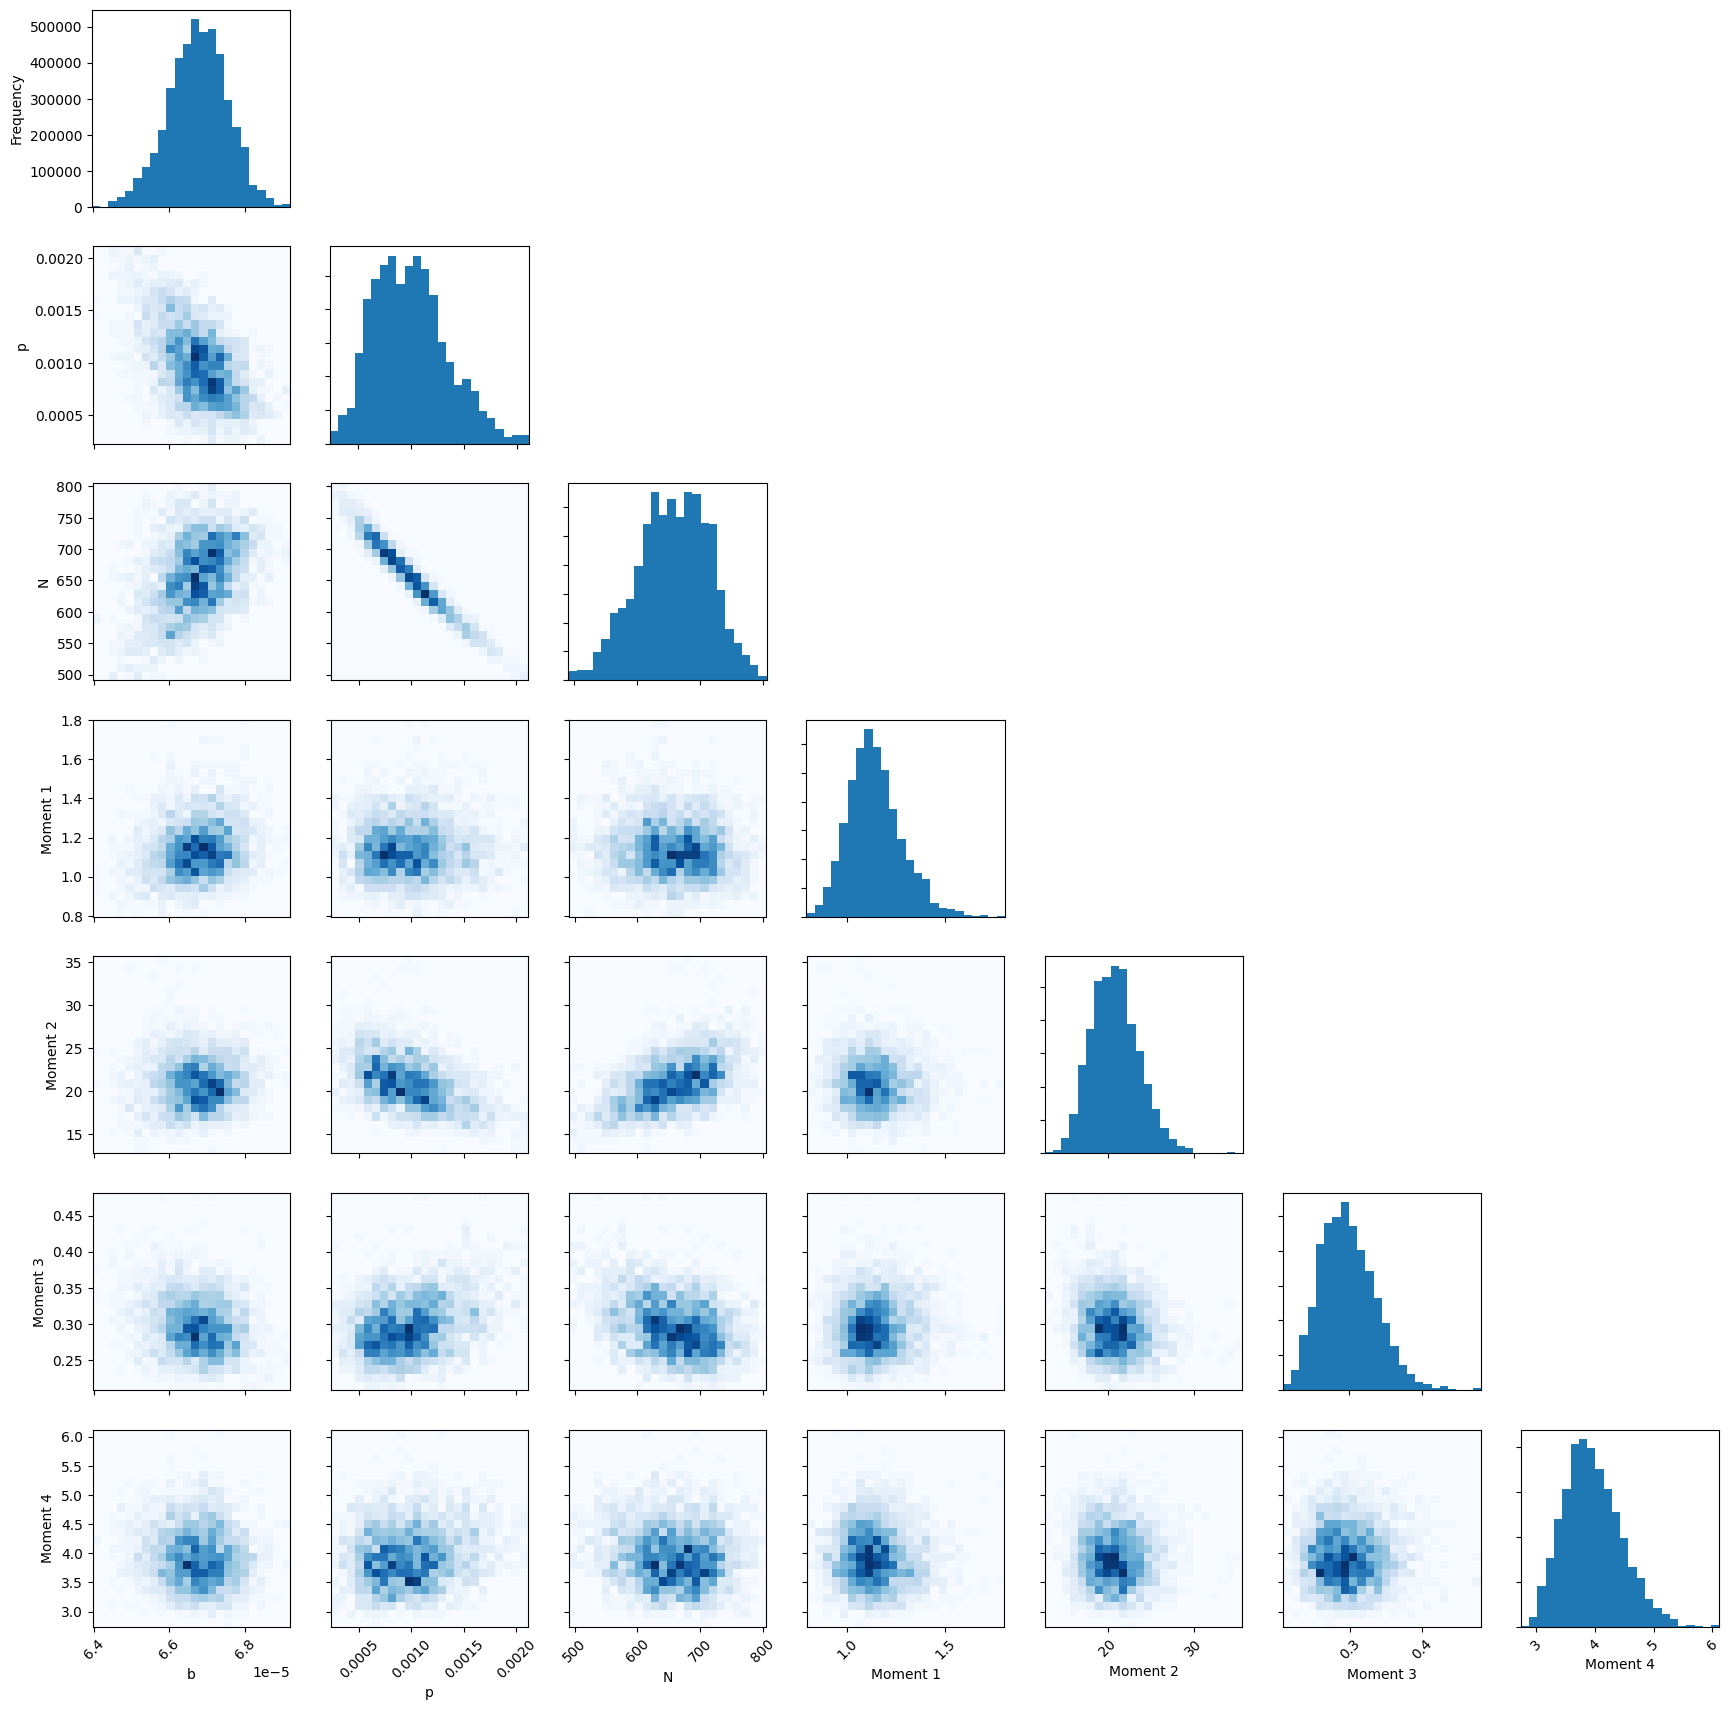

In [23]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

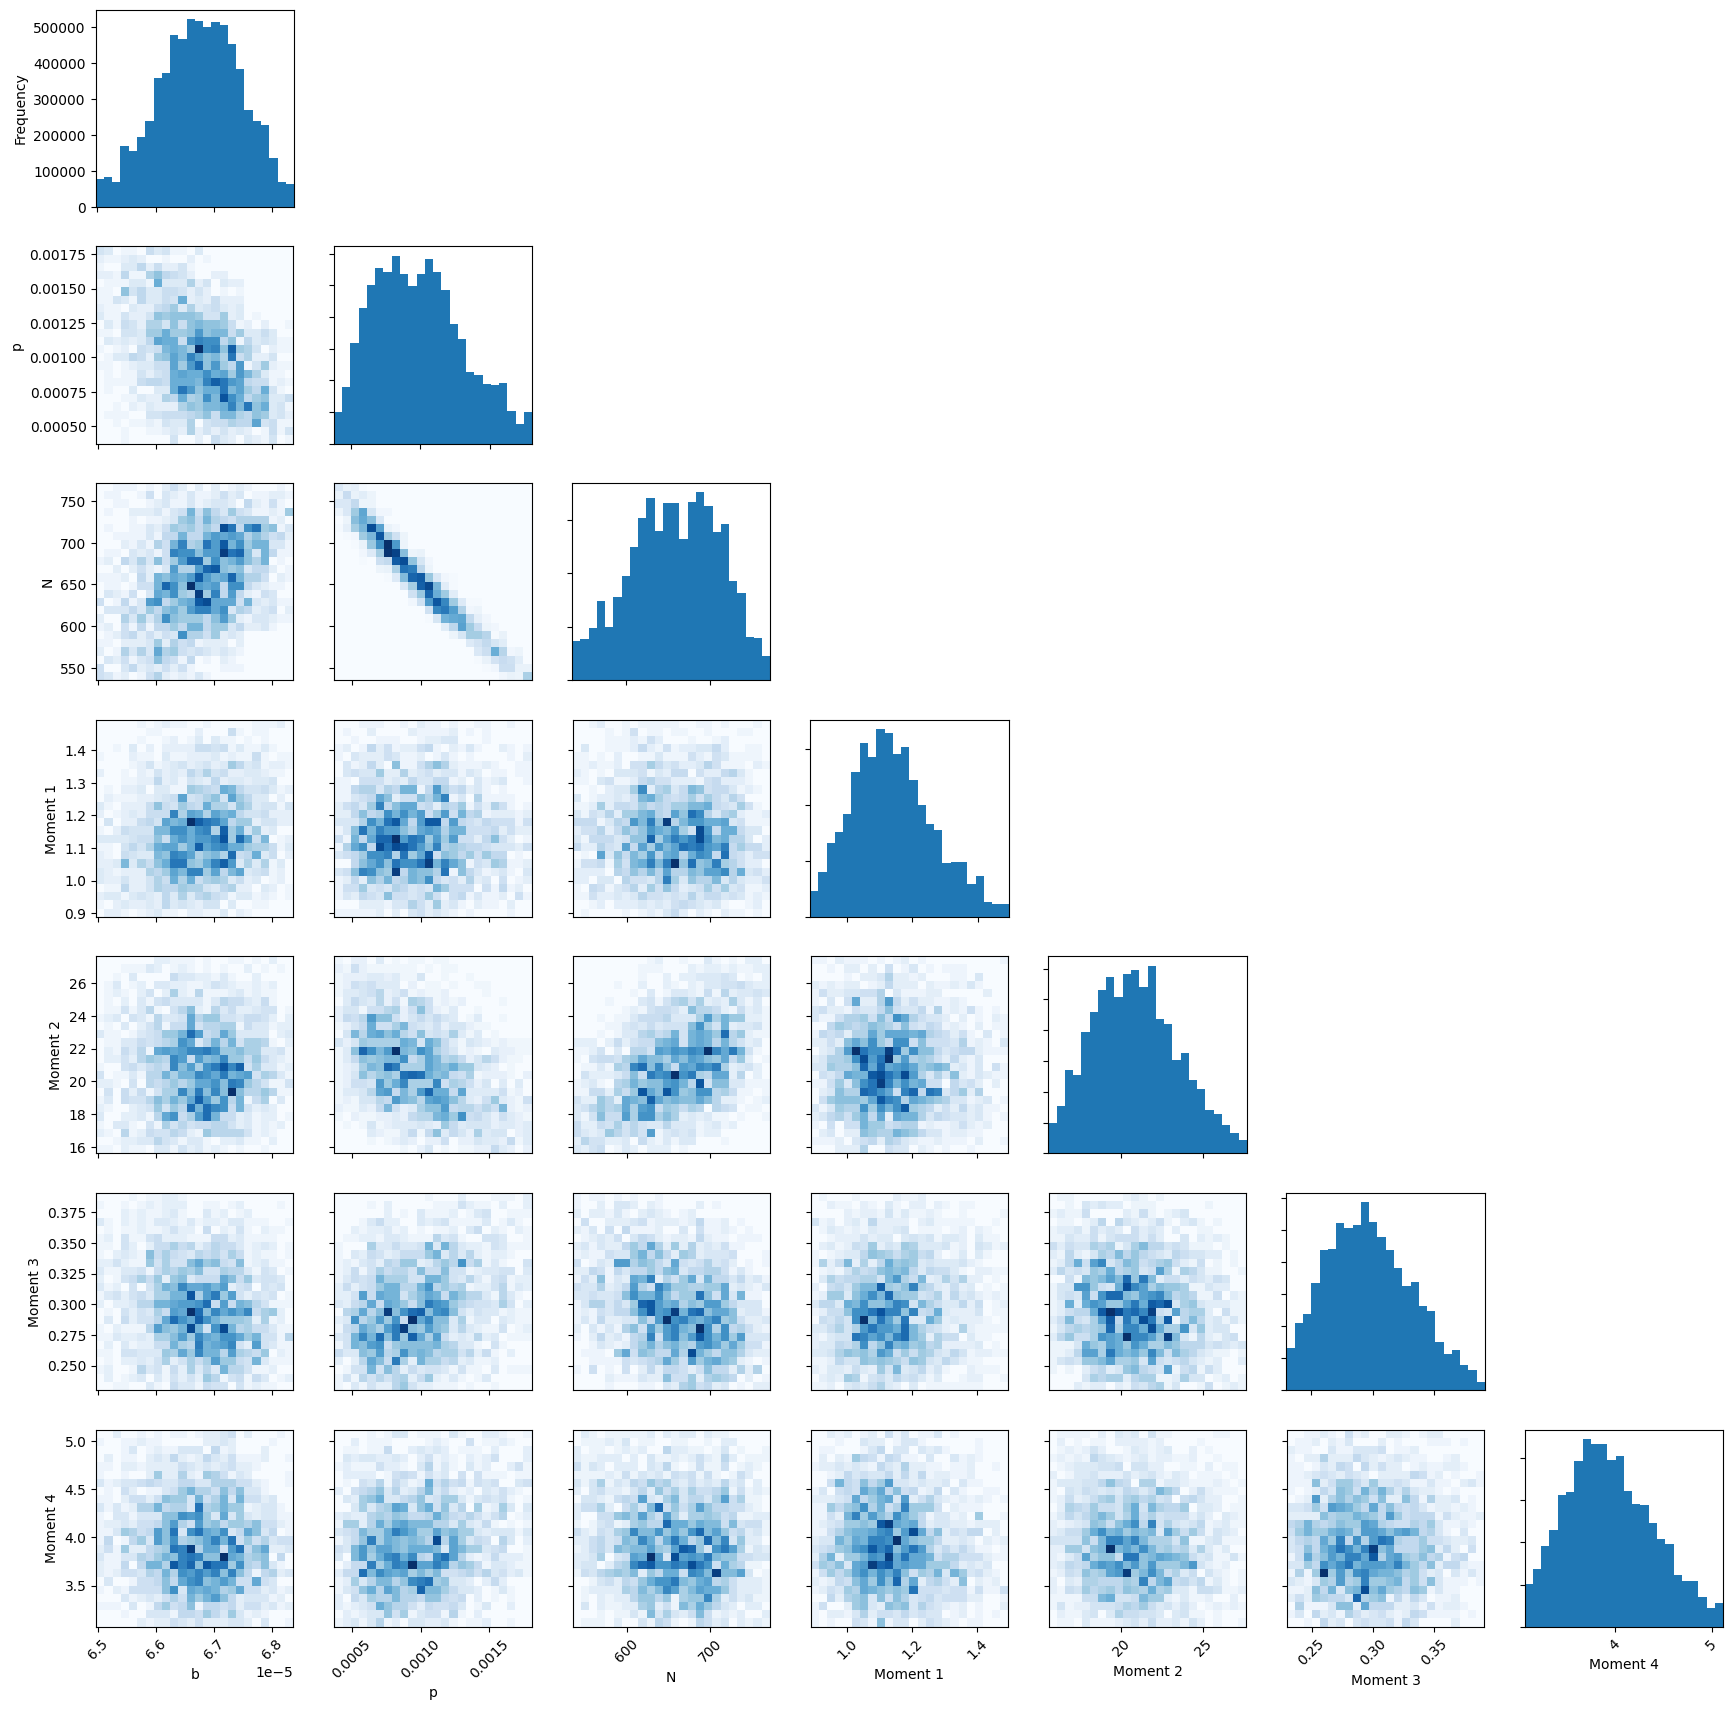

In [24]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

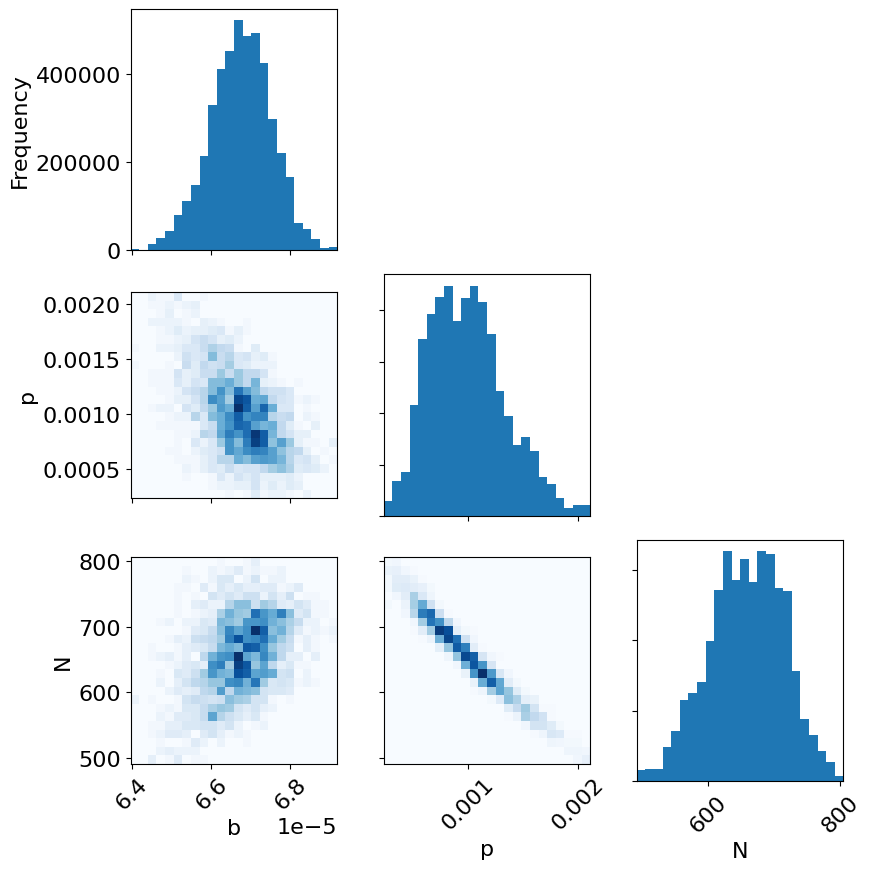

In [55]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'figure.autolayout': True})
parameter_names = ["b","p", "N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

# pints.plot.pairwise(AllChains[:,[0,1,2]], heatmap=True, 
#                     parameter_names=["b","p", "N"])
pints.plot.pairwise(AllChains[:,[0,1,2]], heatmap=True, 
                    parameter_names=["b","p", "N"])
plt.gcf()
plt.savefig("clus_size_pro_pro_cells.png", dpi=300)
plt.show()

In [ ]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


In [27]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [28]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         6.68e-05  8.02e-07  6.51e-05  6.62e-05  6.68e-05  6.73e-05  6.83e-05  1.05    161    0.227
p         0.00095   0.000339  0.000443  0.000689  0.000895  0.00116   0.0018    1.19    36     0.051
N         664       55.5      539       627       672       706       758       1.17    37.6   0.0532
Moment 1  1.14      0.137     0.908     1.05      1.13      1.22      1.44      1       391    0.554
Moment 2  21.1      2.87      16.2      19.1      20.9      22.9      27        1.03    174    0.247
Moment 3  0.297     0.0377    0.234     0.269     0.294     0.322     0.375     1.01    329    0.466
Moment 4  3.95      0.488     3.12      3.61      3.91      4.27      5         1       360    0.509


In [32]:
import math
print(math.log(4))
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)


BIC = len(results.mean())*math.log(4) - 2*log_likelihood(results.mean())

print(BIC)

1.3862943611198906
7
741.2090823977028
736.913142925542


In [34]:
shape_chains = np.shape(AllChains)

DIC_1 = 0
for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    DIC_1 += -2*log_likelihood(thetas)

DIC_1 = DIC_1/shape_chains[0]

DIC_2 = -2*log_likelihood(results.mean())

DIC = 2*DIC_1 - DIC_2

print(DIC)



740.8138706704165


In [ ]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

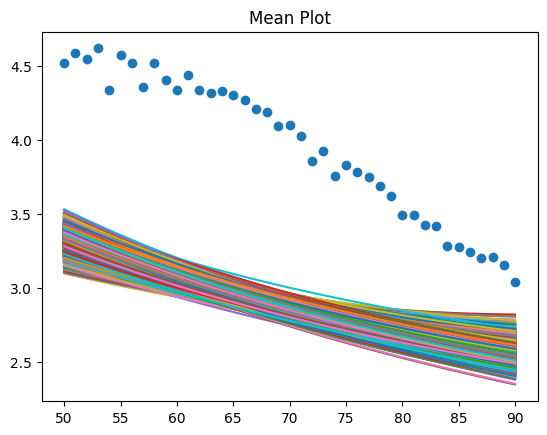

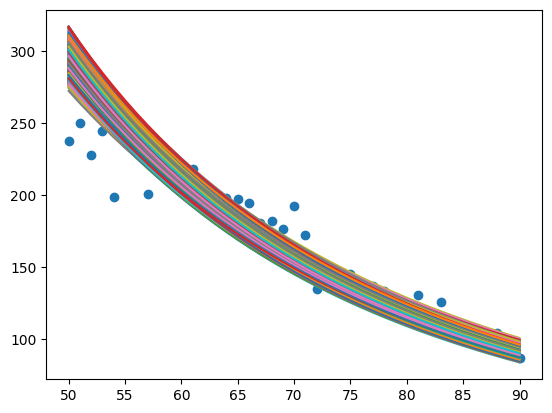

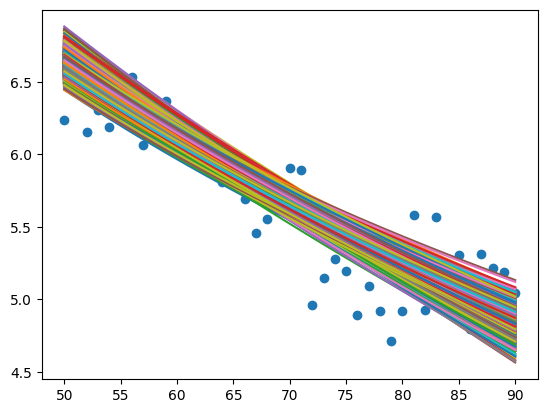

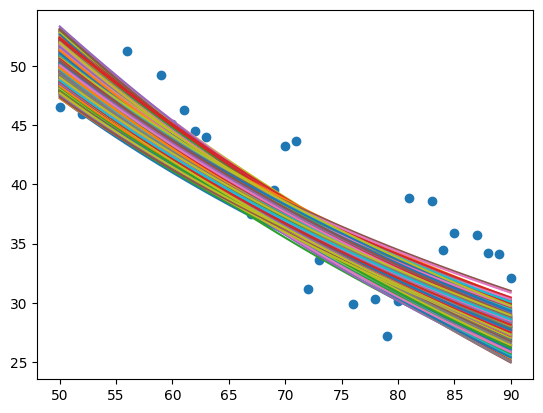

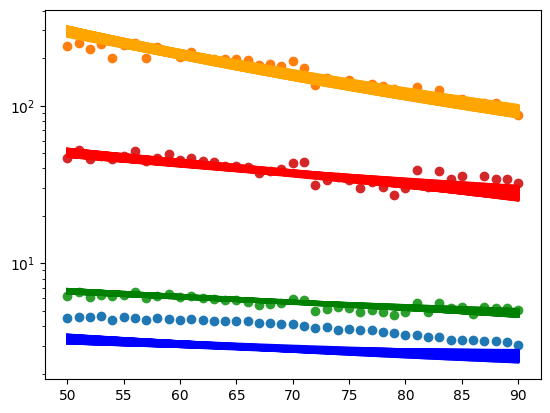

In [42]:
shape_chains = np.shape(AllChains)



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

plt.figure(1)
plt.title("Mean Plot")
plt.scatter(times, data_mean)
plt.figure(2)
plt.scatter(times, data_variance)
plt.figure(3)
plt.scatter(times, data_skewness)
plt.figure(4)
plt.scatter(times, data_kurtosis)

plt.figure(5)
plt.yscale("log")
plt.scatter(times, data_mean)
plt.scatter(times, data_variance)
plt.scatter(times, data_skewness)
plt.scatter(times, data_kurtosis)

for i in range(shape_chains[0]):
    thetas = AllChains[i,:]
    values = model.simulate(thetas[[0,1,2]], times)
    plt.figure(1)
    plt.plot(times,values[:,0])
    plt.figure(2)
    plt.plot(times,values[:,1])
    plt.figure(3)
    plt.plot(times,values[:,2])
    plt.figure(4)
    plt.plot(times,values[:,3])
    plt.figure(5)
    plt.plot(times,values[:,0],color='b')
    plt.plot(times,values[:,1],color='orange')
    plt.plot(times,values[:,2],color='g')
    plt.plot(times,values[:,3],color='r')

plt.show()
plt.show()
plt.show()
plt.show()
plt.show()

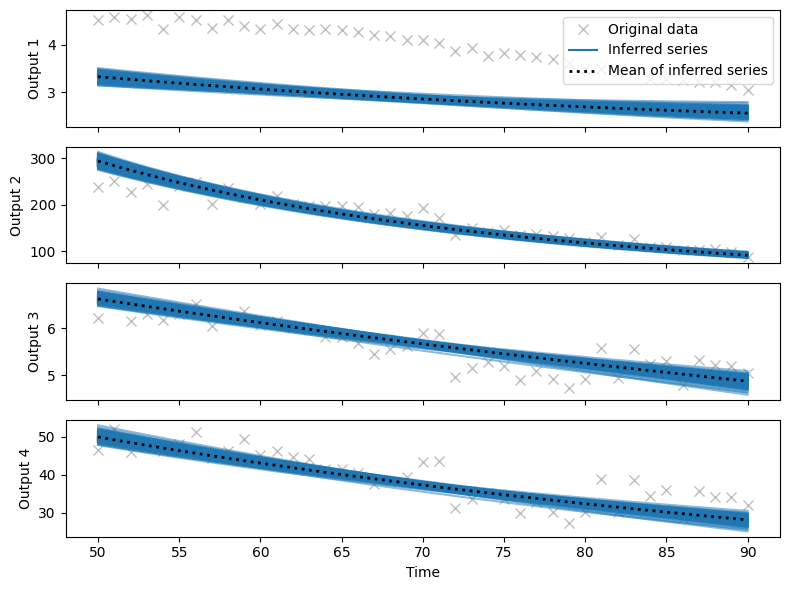

In [33]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

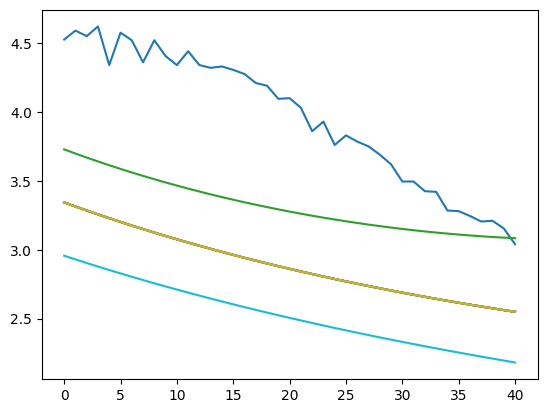

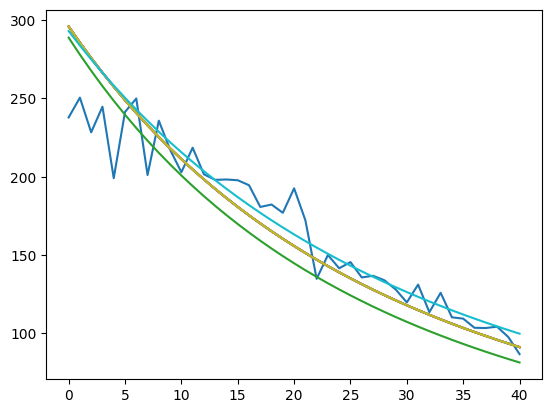

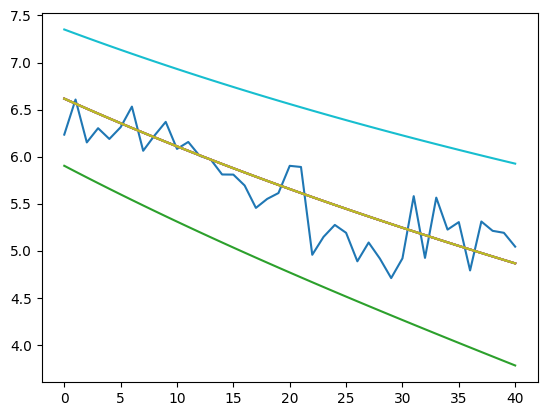

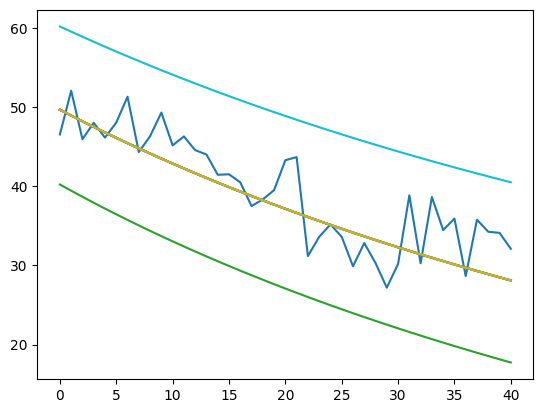

In [35]:



data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] += 2*st_devs[1] 
CI_2[2] -= 2*st_devs[2]

CI_3 = means
CI_3[0] += 2*st_devs[0]
CI_3[1] -= 2*st_devs[1] 
CI_3[2] += 2*st_devs[2]

CI_4 = means
CI_4[0] -= 2*st_devs[0]
CI_4[1] += 2*st_devs[1] 
CI_4[2] += 2*st_devs[2]

CI_5 = means
CI_5[0] += 2*st_devs[0]
CI_5[1] -= 2*st_devs[1] 
CI_5[2] -= 2*st_devs[2]

CI_6 = means
CI_6[0] -= 2*st_devs[0]
CI_6[1] += 2*st_devs[1] 
CI_6[2] -= 2*st_devs[2]

CI_7 = means
CI_7[0] -= 2*st_devs[0]
CI_7[1] -= 2*st_devs[1] 
CI_7[2] += 2*st_devs[2] 

CI_8 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
values_5 = model.simulate(CI_5, times)
values_6 = model.simulate(CI_6, times)
values_7 = model.simulate(CI_7, times)
values_8 = model.simulate(CI_8, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.plot(values_5[:,0])
plt.plot(values_6[:,0])
plt.plot(values_7[:,0])
plt.plot(values_8[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.plot(values_5[:,1])
plt.plot(values_6[:,1])
plt.plot(values_7[:,1])
plt.plot(values_8[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.plot(values_5[:,2])
plt.plot(values_6[:,2])
plt.plot(values_7[:,2])
plt.plot(values_8[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.plot(values_5[:,3])
plt.plot(values_6[:,3])
plt.plot(values_7[:,3])
plt.plot(values_8[:,3])
plt.show()

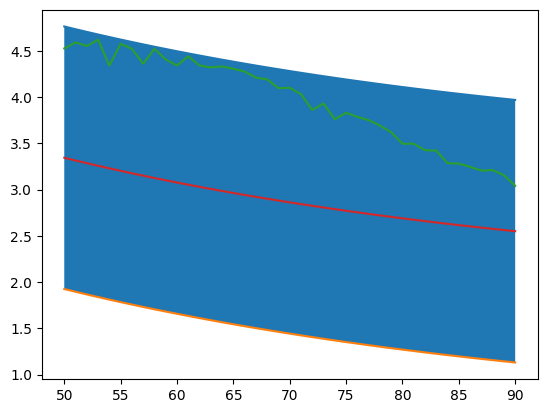

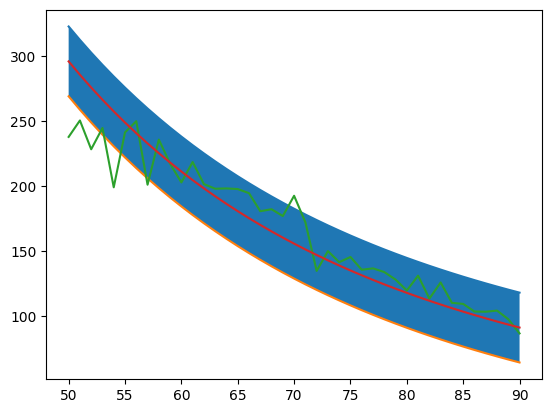

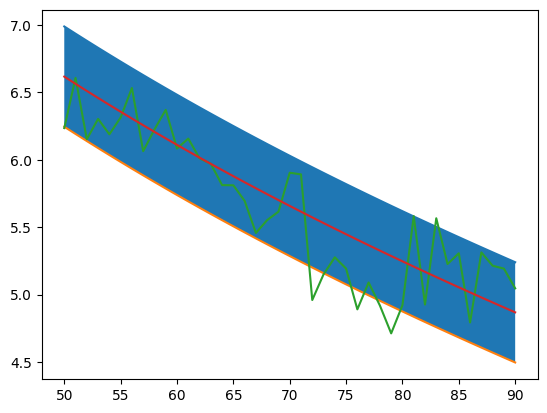

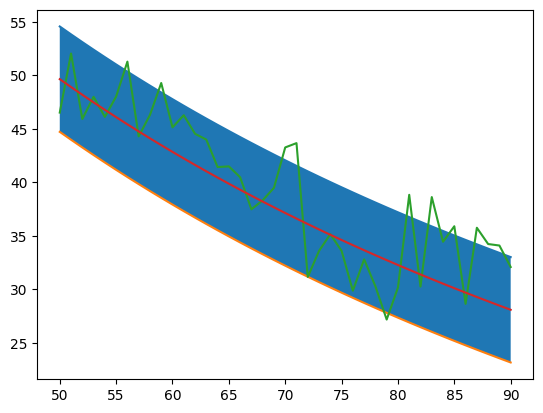

In [37]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1,2]]
st_devs = results.std()[[0,1,2]]

mean_CI = results.mean()[[3,4,5,6]]
st_devs_CI = results.std()[[3,4,5,6]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(50,90,41)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
